In [1]:
from keras.layers import Input, Embedding, Concatenate, Flatten, Dense, Dot, Add, Multiply, Subtract, Average, Reshape
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping

In [2]:
import pandas as pd
import numpy as np 
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In [3]:
df=pd.read_pickle('/home/elena/Projects/DLRM-with-Keras-for-movielens-dataset/ratings_movie_info.pkl')

In [4]:
df.describe()

,user_id,movie_id,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


In [5]:
df.dtypes

user_id             int64
movie_id            int64
rating            float64
unix_timestamp     object
title              object
genre              object
dtype: object

In [6]:
from sklearn.model_selection import train_test_split
import math

In [18]:
# train test split
# Shuffle (reproducibly)
df = df.sample(frac=1, random_state=1).reset_index(drop=True)

# Partitioning train/val according to behaviour of keras.Model.fit() when called with
# validation_split kwarg (which is to take validation data from the end as a contiguous
# chunk)
val_split = .15
n_ratings = len(df)
n_train = math.floor(n_ratings * (1-val_split))
itrain = df.index[:n_train]
ival = df.index[n_train:]
train=df.loc[itrain]
test=df.loc[ival]

In [19]:
train.shape, test.shape, train.user_id.unique().shape[0], test.user_id.unique().shape[0]

((85710, 7), (15126, 7), 610, 609)

In [20]:
len(set(test.user_id.unique()).intersection(set(train.user_id.unique()))), len(set(test.user_id.unique()).difference(set(train.user_id.unique())))

(609, 0)

In [21]:
# center rating
mean_rating_train =  df.loc[itrain, 'rating'].mean()
df['y'] = df['rating'] -mean_rating_train

In [22]:
df.head()

,user_id,movie_id,rating,unix_timestamp,title,genre,y
0,275,1392,5.0,1049076638,Citizen Ruth (1996),Comedy|Drama,1.496897
1,182,2841,4.0,1063284555,Stir of Echoes (1999),Horror|Mystery|Thriller,0.496897
2,89,167380,4.5,1520409150,A Dog's Purpose (2017),Comedy|Drama,0.996897
3,369,1625,4.5,1237082077,"Game, The (1997)",Drama|Mystery|Thriller,0.996897
4,517,277,5.0,1487955694,Miracle on 34th Street (1994),Drama,1.496897


In [23]:
train['y'] = train['rating']-mean_rating_train
test['y'] = test['rating'] - mean_rating_train

In [24]:
train.to_pickle('/home/elena/Projects/DLRM-with-Keras-for-movielens-dataset/ratings_movie_info_train.pkl')
test.to_pickle('/home/elena/Projects/DLRM-with-Keras-for-movielens-dataset/ratings_movie_info_test.pkl')

In [25]:
movie_embedding_size = 8
user_embedding_size = 8

def embedding_model(df, user_embedding_size, movie_embedding_size):
    hidden_units = (32,4)

    # Each instance will consist of two inputs: a single user id, and a single movie id
    user_id_input = Input(shape=(1,), name='user_id')
    movie_id_input = Input(shape=(1,), name='movie_id')
    user_embedded = Embedding(df.user_id.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
    movie_embedded = Embedding(df.movie_id.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)
    # Concatenate the embeddings (and remove the useless extra dimension)
    concatenated = Concatenate()([user_embedded, movie_embedded])
    out = Flatten()(concatenated)

    # Add one or more hidden layers
    for n_hidden in hidden_units:
        out = Dense(n_hidden, activation='relu')(out)

    # A single output: our predicted rating
    out = Dense(1, activation='linear', name='prediction')(out)

    model = Model(inputs = [user_id_input, movie_id_input],outputs = out)
    #compile
    model.compile(optimizer = 'Adam',loss='MSE',metrics=['MAE'])
    return model


In [26]:
model = embedding_model(df, 8,8)

In [28]:
es=EarlyStopping(monitor='val_MAE', min_delta=0, patience=0, verbose=0, mode='min', baseline=None, restore_best_weights=False)
history=model.fit(x=[df.user_id, df.movie_id], y=df.y, batch_size=500,epochs=20, verbose=1, validation_split = 0.15 , callbacks=[es])

Epoch 1/20
172/172 [==============================] - 3s 16ms/step - loss: 0.6435 - MAE: 0.6101 - val_loss: 0.7100 - val_MAE: 0.6422
Epoch 2/20
172/172 [==============================] - 3s 16ms/step - loss: 0.6232 - MAE: 0.5996 - val_loss: 0.7020 - val_MAE: 0.6359
Epoch 3/20
172/172 [==============================] - 3s 16ms/step - loss: 0.6066 - MAE: 0.5903 - val_loss: 0.6962 - val_MAE: 0.6349
Epoch 4/20
172/172 [==============================] - 3s 16ms/step - loss: 0.5917 - MAE: 0.5817 - val_loss: 0.6943 - val_MAE: 0.6310
Epoch 5/20
172/172 [==============================] - 3s 16ms/step - loss: 0.5788 - MAE: 0.5743 - val_loss: 0.6944 - val_MAE: 0.6304
Epoch 6/20
172/172 [==============================] - 3s 16ms/step - loss: 0.5672 - MAE: 0.5676 - val_loss: 0.6949 - val_MAE: 0.6319


In [29]:
model2 = embedding_model(df, 50, 50)
history2=model2.fit(x=[df.user_id, df.movie_id], y=df.y, batch_size=500,epochs=20, verbose=1, validation_split = 0.15 , callbacks=[es])

Epoch 1/20
172/172 [==============================] - 24s 137ms/step - loss: 0.9133 - MAE: 0.7405 - val_loss: 0.7789 - val_MAE: 0.6726
Epoch 2/20
172/172 [==============================] - 23s 133ms/step - loss: 0.7110 - MAE: 0.6445 - val_loss: 0.7397 - val_MAE: 0.6558
Epoch 3/20
172/172 [==============================] - 23s 137ms/step - loss: 0.6508 - MAE: 0.6140 - val_loss: 0.7336 - val_MAE: 0.6530
Epoch 4/20
172/172 [==============================] - 24s 140ms/step - loss: 0.6182 - MAE: 0.5956 - val_loss: 0.7339 - val_MAE: 0.6545


In [30]:
model3 = embedding_model(df, 3, 3)
history3=model2.fit(x=[df.user_id, df.movie_id], y=df.y, batch_size=500,epochs=20, verbose=1, validation_split = 0.15 , callbacks=[es])

Epoch 1/20
172/172 [==============================] - 23s 134ms/step - loss: 0.5907 - MAE: 0.5803 - val_loss: 0.7436 - val_MAE: 0.6600
Epoch 2/20
172/172 [==============================] - 24s 137ms/step - loss: 0.5637 - MAE: 0.5646 - val_loss: 0.7542 - val_MAE: 0.6600
Epoch 3/20
172/172 [==============================] - 24s 140ms/step - loss: 0.5338 - MAE: 0.5471 - val_loss: 0.7680 - val_MAE: 0.6671


In [31]:
def get_metrics(y_true, y_pred):
    return metrics.mean_absolute_error(y_true, y_pred), metrics.mean_squared_error(y_true, y_pred)

mean_rating = train['rating'].mean()
print("Average rating in training set is {:.2f} stars".format(mean_rating))

y_true = test['rating'].values
always_mean = np.full(y_true.shape, mean_rating)

mae, mse = get_metrics(y_true, always_mean)
print("Always predicting global average rating results in Mean Absolute Error={:.2f}, Mean Squared Error={:.2f}".format(
    mae, mse))

movies = df.copy().set_index('movie_id')
mean_per_movie = train.groupby('movie_id')['rating'].mean()
movies['mean_rating'] = mean_per_movie
ratings_per_movie = train.groupby('movie_id').size()
movies['n_ratings'] = ratings_per_movie
# There are a few movies in the validation set not present in the training set. We'll just use the global
# mean rating in their case.
y_movie_mean = test.join(mean_per_movie, on='movie_id', rsuffix='mean')['ratingmean'].fillna(mean_rating).values

mae, mse = get_metrics(y_true, y_movie_mean)
print("Predicting mean per movie results in Mean Absolute Error={:.2f}, Mean Squared Error={:.2f}".format(mae, mse))

Average rating in training set is 3.50 stars
Always predicting global average rating results in Mean Absolute Error=0.83, Mean Squared Error=1.09
Predicting mean per movie results in Mean Absolute Error=0.75, Mean Squared Error=0.95


In [32]:
import matplotlib.pyplot as plt

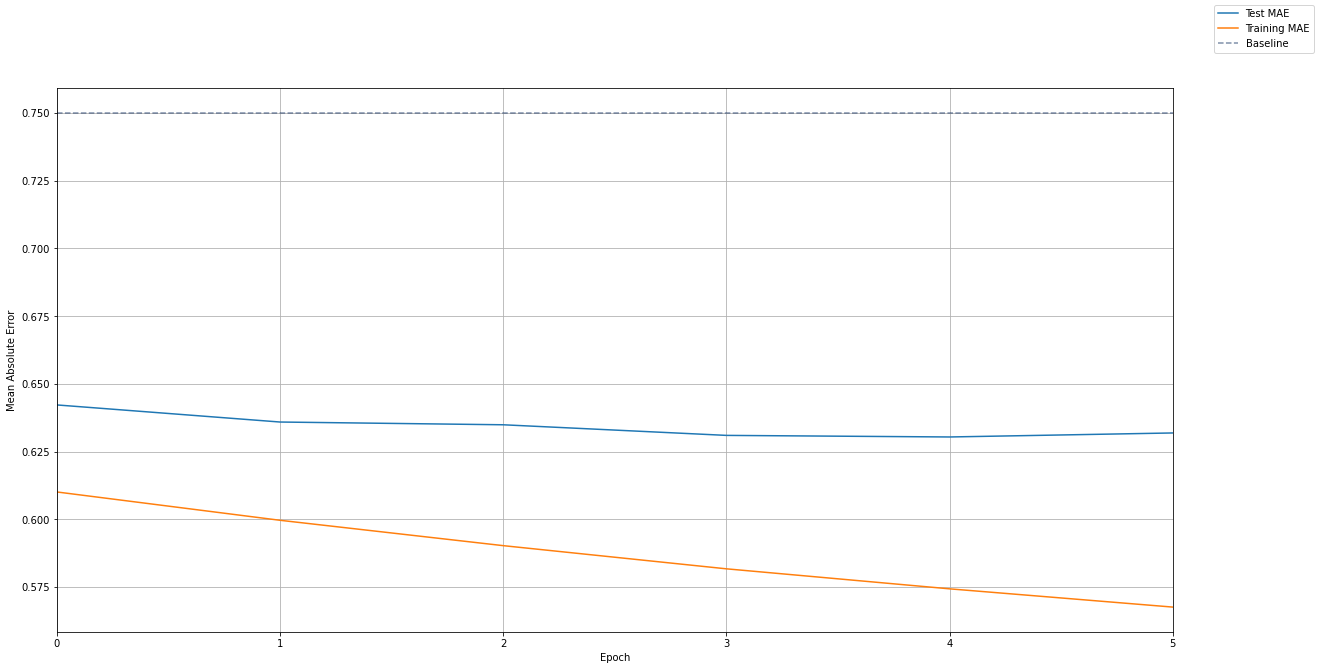

In [33]:
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(history.epoch, history.history['val_MAE'], label='Test MAE')
ax.plot(history.epoch, history.history['MAE'], label='Training MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0, right=history.epoch[-1])
baseline_mae = 0.75
ax.axhline(baseline_mae, ls='--', label='Baseline', color='#002255', alpha=.5)
ax.grid()
fig.legend()
plt.savefig('output.png', dpi=400, bbox_inches='tight')
plt.show()

In [152]:
#Example predictions
ratings_per_user = df.groupby('user_id').size()
uid = ratings_per_user[ratings_per_user < 30].sample(1, random_state=1).index[0]
user_ratings_train = train[train.user_id==uid]
print("User #{} has rated {} movies from the train dataset (avg. rating = {:.1f}):".format(
    uid, len(user_ratings_train), user_ratings_train['rating'].mean(),
))
cols = ['user_id', 'movie_id', 'rating', 'title', 'genre']
user_ratings_train.sort_values(by='rating', ascending=False)[['movie_id', 'rating','title','genre']]

User #557 has rated 23 movies from the train dataset (avg. rating = 3.8):


,movie_id,rating,title,genre
78293,5618,5.0,Spirited Away (Sen to Chihiro no kamikakushi) ...,Adventure|Animation|Fantasy
41027,648,5.0,Mission: Impossible (1996),Action|Adventure|Mystery|Thriller
40411,1036,5.0,Die Hard (1988),Action|Crime|Thriller
5035,10,4.5,GoldenEye (1995),Action|Adventure|Thriller
7201,2571,4.5,"Matrix, The (1999)",Action|Sci-Fi|Thriller
77460,1485,4.5,Liar Liar (1997),Comedy
15640,2617,4.5,"Mummy, The (1999)",Action|Adventure|Comedy|Fantasy|Horror|Thriller
24033,4896,4.5,Harry Potter and the Sorcerer's Stone (a.k.a. ...,Adventure|Children|Fantasy
52338,150,4.5,Apollo 13 (1995),Adventure|Drama|IMAX
66997,60069,4.0,WALL·E (2008),Adventure|Animation|Children|Romance|Sci-Fi


In [79]:
user_ratings_test = test[test.user_id == uid]

In [80]:
user_ratings_test

,user_id,movie_id,rating,unix_timestamp,title,genre,y
89235,557,165,5.0,1452797740,Die Hard: With a Vengeance (1995),Action|Crime|Thriller,1.496897
94849,557,134130,3.5,1452934442,The Martian (2015),Adventure|Drama|Sci-Fi,-0.003103
95106,557,318,4.5,1452797268,"Shawshank Redemption, The (1994)",Crime|Drama,0.996897
99995,557,4306,4.5,1452797727,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...,0.996897


In [81]:
# predicting for user uid movies from test set
y_pred = model.predict([user_ratings_test.user_id, user_ratings_test.movie_id])

In [82]:
y_true = user_ratings_test.y

In [83]:
y_delta = mean_rating

In [84]:
y_pred.shape

(4, 1)

In [85]:
result = pd.DataFrame()
result['predicted_rating'] = np.squeeze(y_pred) + y_delta

In [86]:
result['true_rating'] = y_true.values + y_delta
result['movie_id'] = user_ratings_test.movie_id.values

In [87]:
result['error'] = abs(np.squeeze(y_pred) - np.squeeze(y_true.values))
result.sort_values(by='error', ascending=True)[['movie_id','true_rating', 'predicted_rating', 'error']]

,movie_id,true_rating,predicted_rating,error
1,134130,3.5,3.905294,0.405294
2,318,4.5,4.035668,0.464332
3,4306,4.5,4.001062,0.498938
0,165,5.0,3.707034,1.292966


In [88]:
result.error.mean()

0.6653824218497222

In [151]:
pd.merge(user_ratings_test, result, on='movie_id').sort_values(by='error', ascending=True)[['true_rating', 'predicted_rating', 'error','title', 'genre']]

,true_rating,predicted_rating,error,title,genre
1,3.5,3.905294,0.405294,The Martian (2015),Adventure|Drama|Sci-Fi
2,4.5,4.035668,0.464332,"Shawshank Redemption, The (1994)",Crime|Drama
3,4.5,4.001062,0.498938,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...
0,5.0,3.707034,1.292966,Die Hard: With a Vengeance (1995),Action|Crime|Thriller


In [156]:
# die hard investigation
diehard=df[(df.movie_id==165) | (df.movie_id==1036)]

In [158]:
diehard_train=train[(train.movie_id==165) | (train.movie_id==1036)]
diehard_test=test[(test.movie_id==165) | (test.movie_id==1036)]

In [159]:
diehard.groupby('movie_id').mean()['rating']

movie_id
165     3.555556
1036    3.862069
Name: rating, dtype: float64

In [160]:
diehard_train.groupby('movie_id').mean()['rating']

movie_id
165     3.500000
1036    3.886179
Name: rating, dtype: float64

In [161]:
diehard_test.groupby('movie_id').mean()['rating']

movie_id
165     3.785714
1036    3.727273
Name: rating, dtype: float64

In [131]:
# Show top 10 movie recommendations to a user
# Let us get a user and see the top recommendations.
movies_watched_by_user = df[df.user_id == uid]
movies_not_watched = list(set(df.movie_id.unique()).difference(set(movies_watched_by_user.movie_id.unique())))

In [116]:
type(movies_not_watched)

list

In [133]:
movies_not_watched=pd.DataFrame(movies_not_watched, columns = ['movie_id'])

In [134]:
movies_not_watched['user_id'] = uid
movies_not_watched.head()

,movie_id,user_id
0,1,557
1,2,557
2,3,557
3,4,557
4,5,557


In [135]:
ratings_user = model.predict([movies_not_watched.user_id, movies_not_watched.movie_id])


In [136]:
movies_not_watched['predicted_ratings'] = ratings_user +y_delta

In [137]:
movies_not_watched=movies_not_watched.sort_values(by='predicted_ratings', ascending=False)

In [138]:
movies_not_watched.head(10)

,movie_id,user_id,predicted_ratings
7031,177593,557,4.660729
9488,64197,557,4.556700
7254,113829,557,4.553651
5574,7121,557,4.538522
3480,4142,557,4.538311
6658,142020,557,4.530828
3984,4788,557,4.526130
6595,164917,557,4.520685
6515,107951,557,4.515440
7662,117192,557,4.501959


In [164]:
df[df["movie_id"].isin(top_movies_user)].head()

,user_id,movie_id,rating,unix_timestamp,title,genre,y
4866,598,113829,5.0,1430616765,"One I Love, The (2014)",Comedy|Drama|Romance,1.496897
11864,419,64197,5.0,1321853498,Hunger (2008),Drama,1.496897
12489,380,117192,4.0,1494709303,Doctor Who: The Time of the Doctor (2013),Adventure|Drama,0.496897
15944,184,164917,4.5,1537108221,13th (2016),Documentary,0.996897
16206,212,177593,5.0,1527794935,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama,1.496897


In [163]:
print("Showing recommendations for user: {}".format(uid))
print("====" * 9)
top_movies_user = movies_not_watched.head(10).movie_id.values

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = df[df["movie_id"].isin(top_movies_user)]
recommended_movies = recommended_movies.drop_duplicates()
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genre)

Showing recommendations for user: 557
--------------------------------
Top 10 movie recommendations
--------------------------------
One I Love, The (2014) : Comedy|Drama|Romance
Hunger (2008) : Drama
Doctor Who: The Time of the Doctor (2013) : Adventure|Drama
13th (2016) : Documentary
Three Billboards Outside Ebbing, Missouri (2017) : Crime|Drama
Doctor Who: The Time of the Doctor (2013) : Adventure|Drama
Doctor Who: The Time of the Doctor (2013) : Adventure|Drama
Hunger (2008) : Drama
13th (2016) : Documentary
Three Billboards Outside Ebbing, Missouri (2017) : Crime|Drama
Three Billboards Outside Ebbing, Missouri (2017) : Crime|Drama
Adam's Rib (1949) : Comedy|Romance
Left Behind: The Movie (2000) : Action|Adventure|Drama|Thriller
Three Billboards Outside Ebbing, Missouri (2017) : Crime|Drama
Hunting Elephants (2013) : Comedy|Crime
Adam's Rib (1949) : Comedy|Romance
Three Billboards Outside Ebbing, Missouri (2017) : Crime|Drama
Three Billboards Outside Ebbing, Missouri (2017) : Crime